In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [3]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [4]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [5]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

In [6]:
with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_63rd.h5", 'r') as hf:
    flatfield_1d_FeXIV_63rd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_52nd.h5", 'r') as hf:
    flatfield_1d_FeX_52nd = hf['flatfield_1d'][:]

In [7]:
def calculate_intensity(image, wvl, wavelength_slice, ypix_slice, cont_slice_1, cont_slice_2):
    image_sliced = image[ypix_slice, wavelength_slice]
    wvl_sliced = wvl[wavelength_slice]
    if ypix_slice.stop is not None:
        intensity_sliced = np.zeros(ypix_slice.stop - ypix_slice.start)
        cont_sliced = np.zeros(ypix_slice.stop - ypix_slice.start)
    else:
        intensity_sliced = np.zeros(350)
        cont_sliced = np.zeros(350)
        
    for ii in range(len(intensity_sliced)):
        intensity_sliced[ii], cont_sliced[ii] = calculate_intensity_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_sliced[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_sliced[ii,:])

    return intensity_sliced, cont_sliced

def fit_spectra(image, wvl, wavelength_slice, ypix_slice, cont_slice_1, cont_slice_2,nbin=5,plot_fit=False):
    image_sliced = image[ypix_slice, wavelength_slice]
    if (nbin == 1) or (nbin is None):
        pass
    else:
        image_sliced = np.average(image_sliced.reshape(-1,nbin,image_sliced.shape[1]),axis=1)
    wvl_sliced = wvl[wavelength_slice]
    fit_params = np.zeros((4,image_sliced.shape[0]))
    fit_errs = np.zeros((4,image_sliced.shape[0]))

    for ii in range(image_sliced.shape[0]):
        fit_params[:,ii], fit_errs[:,ii] = fit_spectra_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_sliced[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_sliced[ii,:],
                                plot_fit=plot_fit)

    return fit_params, fit_errs

    
def calculate_intensity_single(cont_wvl, cont_int, wvl, int):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)
    int_sum = np.sum(int_res)

    return int_sum, np.mean(cont_fit_poly(wvl))


def fit_spectra_single(cont_wvl, cont_int, wvl, int,plot_fit=False):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)

    fit_model = SpectrumFitSingle(data=int_res,wvl=wvl,line_number=1,
                        line_wvl_init=wvl[np.argmax(int_res)],int_max_init=int_res.max(),fwhm_init=0.1)

    try:
        fit_model.run_lse()
    except RuntimeError:
        pass
    if plot_fit:
        fit_model.plot(plot_params=False)
        print(fit_model.fwhm_fit)

    return np.array([fit_model.line_wvl_fit[0], fit_model.int_total_fit[0], fit_model.fwhm_fit[0],
                     cont_fit_poly(fit_model.line_wvl_fit[0]) + fit_model.int_cont_fit]), \
            np.array([fit_model.line_wvl_err[0], fit_model.int_total_err[0], fit_model.fwhm_err[0],
                    fit_model.int_cont_err])

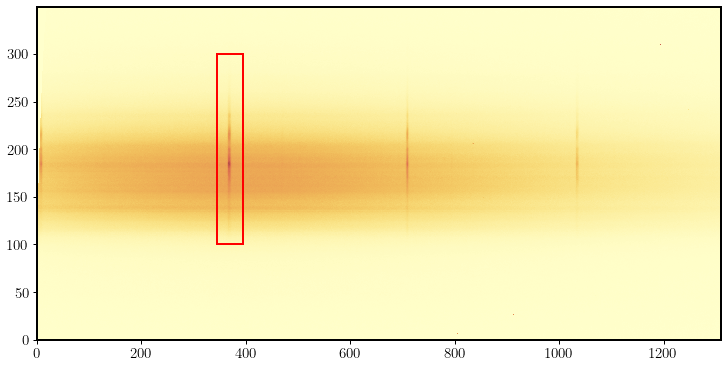

In [8]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
green_frame_example = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=0,unit="adu")
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data
ax.pcolormesh(np.arange(green_frame_example.header["NAXIS1"]),
                np.arange(green_frame_example.header["NAXIS2"]),
                green_frame_example.data,cmap=cmcm.lajolla,rasterized=True)

FeXIV_63rd_xslice = slice(345,395)
FeXIV_63rd_yslice = slice(100,300)
cutout_rectangle_63rd = patches.Rectangle((FeXIV_63rd_xslice.start, FeXIV_63rd_yslice.start), 
                    FeXIV_63rd_xslice.stop - FeXIV_63rd_xslice.start,
                    FeXIV_63rd_yslice.stop - FeXIV_63rd_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)
ax.add_patch(cutout_rectangle_63rd)
ax.tick_params(labelsize=15)

In [57]:
starttime_green_ext = datetime(2017,8,21,17,45,36)
green_fit_matrix_ext = np.full((4,350,188),np.nan,dtype=np.float64)
green_fit_matrix_ext_err = np.full((4,350,188),np.nan,dtype=np.float64)
green_fit_filename_index = np.full(188,np.nan,dtype=np.int32)
for ii, row_ in totality_green_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_green_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
    green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=2,unit="adu").data

    FeXIV_fit_, FeXIV_fit_err_ = fit_spectra(green_frame_.data/flatfield_1d_FeXIV_63rd[:,np.newaxis]/exptime,
    green_frame_wavelength_/63./10., FeXIV_63rd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50), nbin=None)

    green_fit_matrix_ext[:,:,startindex:endindex] = FeXIV_fit_[:,:,np.newaxis]
    green_fit_matrix_ext_err[:,:,startindex:endindex] = FeXIV_fit_err_[:,:,np.newaxis]
    green_fit_filename_index[startindex:endindex] = ii

green_fit_matrix_ext = np.flip(green_fit_matrix_ext,axis=(1,2))
green_fit_matrix_ext_err = np.flip(green_fit_matrix_ext_err,axis=(1,2))
green_fit_filename_index = np.flip(green_fit_filename_index)

In [42]:
green_fit_matrix_bin_ext = np.full((4,70,188),np.nan,dtype=np.float64)
green_fit_matrix_bin_ext_err = np.full((4,70,188),np.nan,dtype=np.float64)
for ii, row_ in totality_green_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_green_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
    green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=2,unit="adu").data

    FeXIV_fit_, FeXIV_fit_err_  = fit_spectra(green_frame_.data/flatfield_1d_FeXIV_63rd[:,np.newaxis]/exptime,
    green_frame_wavelength_/63./10., FeXIV_63rd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50), nbin=5, plot_fit=False)

    green_fit_matrix_bin_ext[:,:,startindex:endindex] = FeXIV_fit_[:,:,np.newaxis]
    green_fit_matrix_bin_ext_err[:,:,startindex:endindex] = FeXIV_fit_err_[:,:,np.newaxis]
green_fit_matrix_bin_ext = np.flip(green_fit_matrix_bin_ext,axis=(1,2))
green_fit_matrix_bin_ext_err = np.flip(green_fit_matrix_bin_ext_err,axis=(1,2))

In [11]:
green_intensity_matrix = np.full((350,188),np.nan)
green_cont_matrix = np.full((350,188),np.nan)

for ii, row_ in totality_green_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_green_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
    green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=1,unit="adu").data

    FeXIV_int_, cont_int_ = calculate_intensity(green_frame_.data/flatfield_1d_FeXIV_63rd[:,np.newaxis]/exptime,green_frame_wavelength_/62., FeXIV_63rd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50))

    green_intensity_matrix[:,startindex:endindex] = FeXIV_int_[:,np.newaxis]
    green_cont_matrix[:,startindex:endindex] = cont_int_[:,np.newaxis]
    
green_intensity_matrix = np.flip(green_intensity_matrix)
green_cont_matrix = np.flip(green_cont_matrix)

In [59]:
with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63rd.h5", 'w') as hf:
    df_green_fit_matrix_ext = hf.create_dataset("green_fit_matrix_ext",  data=green_fit_matrix_ext)
    df_green_fit_matrix_ext_err = hf.create_dataset("green_fit_matrix_ext_err",  data=green_fit_matrix_ext_err)
    df_green_fit_matrix_bin_ext = hf.create_dataset("green_fit_matrix_bin_ext",  data=green_fit_matrix_bin_ext)
    df_green_fit_matrix_bin_ext_err = hf.create_dataset("green_fit_matrix_bin_ext_err",  data=green_fit_matrix_bin_ext_err)
    df_green_fit_filename_index = hf.create_dataset("green_fit_filename_index",  data=green_fit_filename_index)
    df_green_fit_matrix_ext.attrs["description"] = "wvl;int;fwhm;cont"

In [12]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-63,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,93.5,188)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [13]:
img_center = np.array([300,220])

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [14]:
pixel_size_green = np.abs(np.mean(np.diff((green_frame_wavelength_/63./10.)[FeXIV_63rd_xslice])))
inst_width_pix_green = 1.86
inst_width_nm_green = pixel_size_green*inst_width_pix_green

print(pixel_size_green, inst_width_nm_green)

0.024524424947864127 0.04561543040302728


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in sqrt


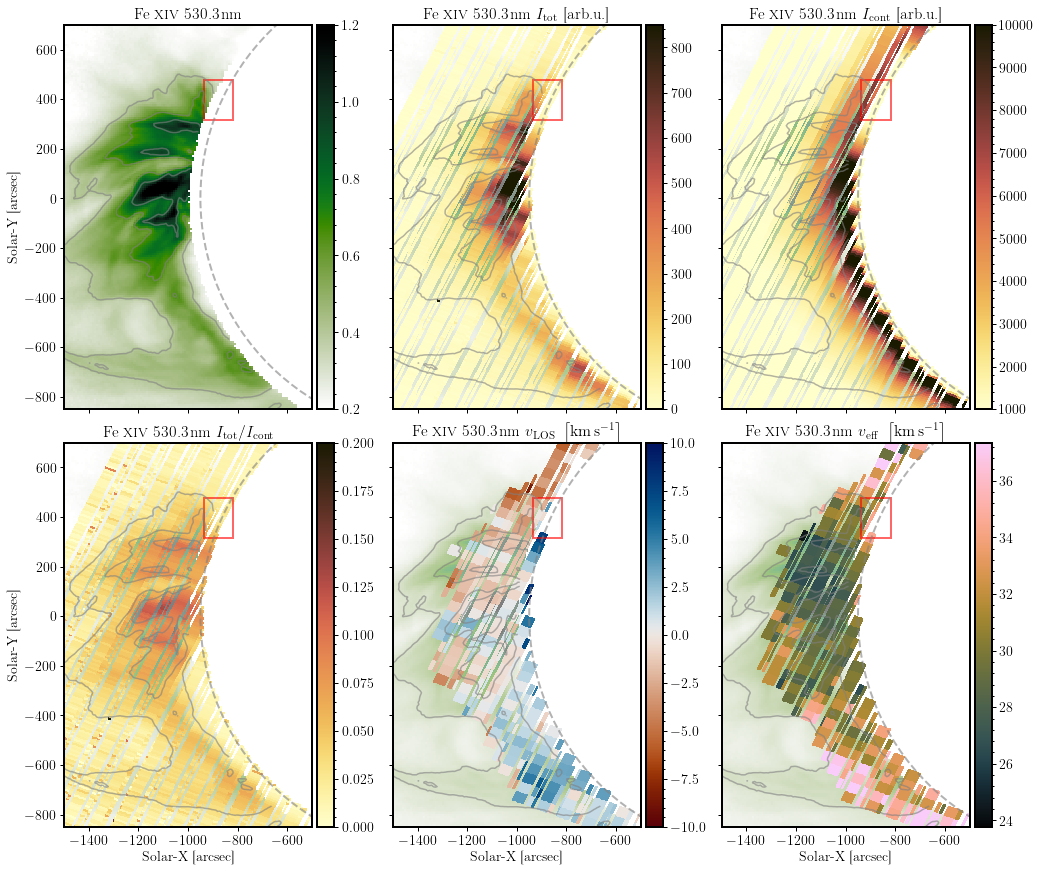

In [15]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)



colorbar_width = "7%"

def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(14,12),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True,alpha=0.5)

green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
green_line_int_masked[green_where_disk_ext] = np.nan

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=850)


plot_colorbar(im2, ax2,width=colorbar_width)

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:])
green_cont_masked[green_where_disk_ext] = np.nan
im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/green_fit_matrix_ext[3,:,:]
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan
im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.2)

plot_colorbar(im4, ax4,width=colorbar_width)

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 50)] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 50)] = np.nan
fwhm_masked[green_where_disk_bin_ext] = np.nan
im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                np.sqrt(fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,cmap=cmcm.batlowK,rasterized=True,vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.11/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3\,nm",fontsize=16)
ax2.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16)
ax3.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16)
ax4.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16)
ax5.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)
ax6.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)

xlim_zoomin = [-1500,-500]
ylim_zoomin = [-850,700]


for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in sqrt


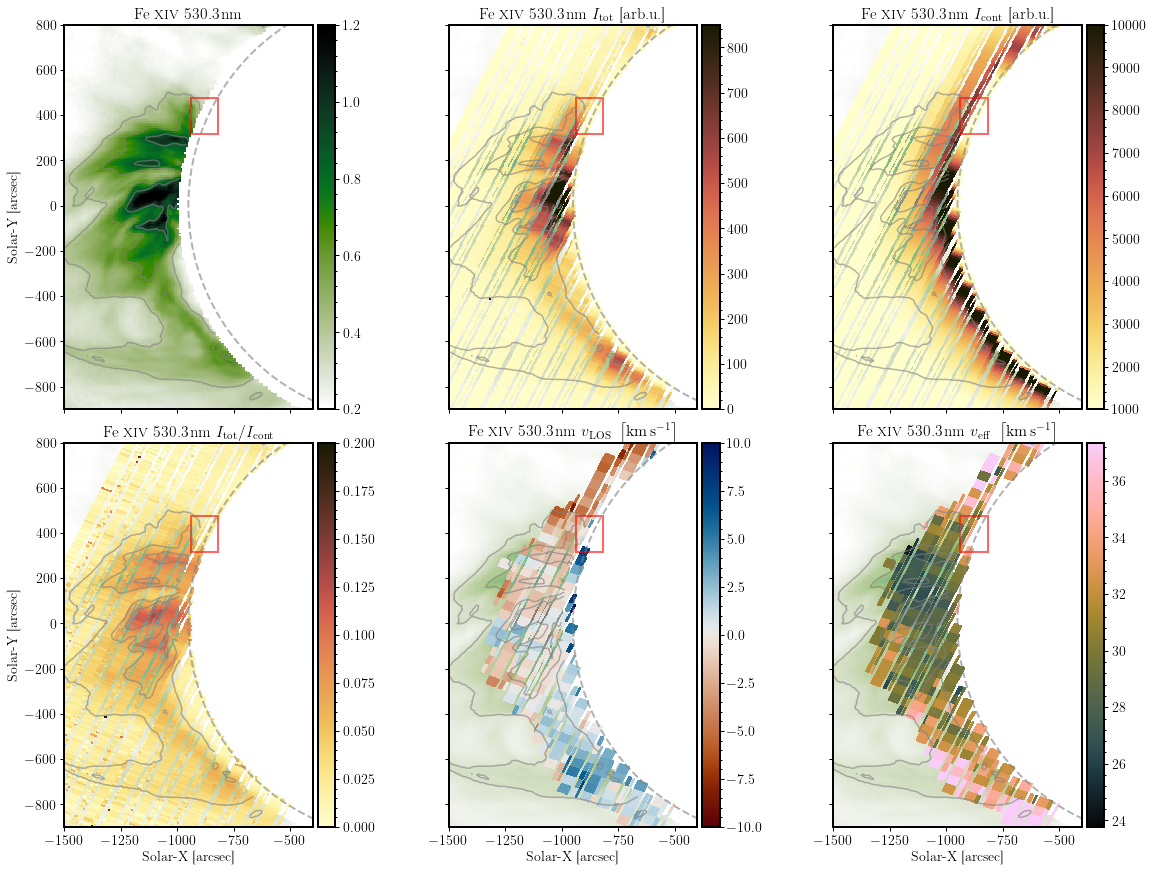

In [16]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)



colorbar_width = "7%"

def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,12),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True,alpha=0.5)

green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
green_line_int_masked[green_where_disk_ext] = np.nan

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=850)


plot_colorbar(im2, ax2,width=colorbar_width)

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:])
green_cont_masked[green_where_disk_ext] = np.nan
im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/green_fit_matrix_ext[3,:,:]
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan
im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.2)

plot_colorbar(im4, ax4,width=colorbar_width)

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 50)] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 50)] = np.nan
fwhm_masked[green_where_disk_bin_ext] = np.nan
im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                np.sqrt(fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,cmap=cmcm.batlowK,rasterized=True,vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.11/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3\,nm",fontsize=16)
ax2.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16)
ax3.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16)
ax4.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16)
ax5.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)
ax6.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)

xlim_zoomin = [-1500,-400]
ylim_zoomin = [-900,800]


for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)

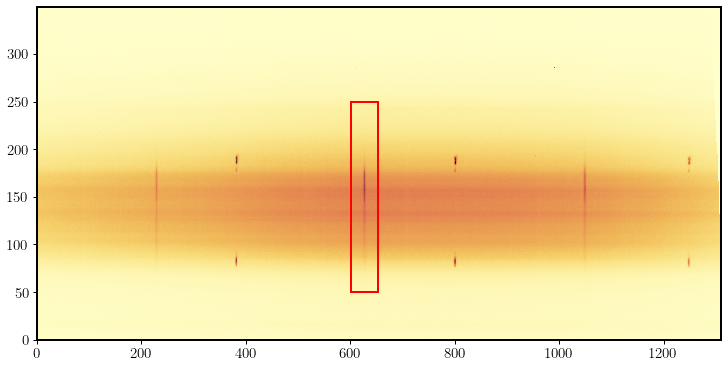

In [17]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
red_frame_example = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=0,unit="adu")
red_frame_wavelength = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data
ax.pcolormesh(np.arange(red_frame_example.header["NAXIS1"]),
                np.arange(red_frame_example.header["NAXIS2"]),
                red_frame_example.data,cmap=cmcm.lajolla,rasterized=True)

FeX_52nd_xslice = slice(602,652)
FeX_52nd_yslice = slice(50,250)
cutout_rectangle_52nd = patches.Rectangle((FeX_52nd_xslice.start, FeX_52nd_yslice.start), 
                    FeX_52nd_xslice.stop - FeX_52nd_xslice.start,
                    FeX_52nd_yslice.stop - FeX_52nd_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)
ax.add_patch(cutout_rectangle_52nd)
ax.tick_params(labelsize=15)

In [62]:
starttime_red_ext = datetime(2017,8,21,17,45,36)
red_fit_matrix_ext = np.full((4,350,176),np.nan,dtype=np.float64)
red_fit_matrix_ext_err = np.full((4,350,176),np.nan,dtype=np.float64)
red_fit_filename_index = np.full(176,np.nan,dtype=np.int32)
for ii, row_ in totality_red_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_red_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    red_frame_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=0,unit="adu")
    red_frame_wavelength_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=2,unit="adu").data

    FeX_fit_, FeX_fit_err_ = fit_spectra(red_frame_.data/flatfield_1d_FeX_52nd[:,np.newaxis]/exptime,
    red_frame_wavelength_/52./10., FeX_52nd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50), nbin=None)

    red_fit_matrix_ext[:,:,startindex:endindex] = FeX_fit_[:,:,np.newaxis]
    red_fit_matrix_ext_err[:,:,startindex:endindex] = FeX_fit_err_[:,:,np.newaxis]
    red_fit_filename_index[startindex:endindex] = ii

red_fit_matrix_ext = np.flip(red_fit_matrix_ext,axis=(1,2))
red_fit_matrix_ext_err = np.flip(red_fit_matrix_ext_err,axis=(1,2))
red_fit_filename_index = np.flip(red_fit_filename_index)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:269: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diagonal(pcov))


In [60]:
red_fit_matrix_bin_ext = np.full((4,70,176),np.nan,dtype=np.float64)
red_fit_matrix_bin_ext_err = np.full((4,70,176),np.nan,dtype=np.float64)
for ii, row_ in totality_red_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_red_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    red_frame_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=0,unit="adu")
    red_frame_wavelength_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=2,unit="adu").data

    FeX_fit_, FeX_fit_err_ = fit_spectra(red_frame_.data/flatfield_1d_FeX_52nd[:,np.newaxis]/exptime,
    red_frame_wavelength_/52./10., FeX_52nd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50), nbin=5, plot_fit=False)

    red_fit_matrix_bin_ext[:,:,startindex:endindex] = FeX_fit_[:,:,np.newaxis]
    red_fit_matrix_bin_ext_err[:,:,startindex:endindex] = FeX_fit_err_[:,:,np.newaxis]
red_fit_matrix_bin_ext = np.flip(red_fit_matrix_bin_ext,axis=(1,2))
red_fit_matrix_bin_ext_err = np.flip(red_fit_matrix_bin_ext_err,axis=(1,2))

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:269: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diagonal(pcov))
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [20]:
red_intensity_matrix = np.full((350,176),np.nan)
red_cont_matrix = np.full((350,176),np.nan)

for ii, row_ in totality_red_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_red_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    red_frame_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=0,unit="adu")
    red_frame_wavelength_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=1,unit="adu").data

    FeX_int_, cont_int_ = calculate_intensity(red_frame_.data/flatfield_1d_FeX_52nd[:,np.newaxis]/exptime,red_frame_wavelength_/52., FeX_52nd_xslice, slice(0,None), 
                    slice(0,10),slice(40,50))

    red_intensity_matrix[:,startindex:endindex] = FeX_int_[:,np.newaxis]
    red_cont_matrix[:,startindex:endindex] = cont_int_[:,np.newaxis]
    
red_intensity_matrix = np.flip(red_intensity_matrix)
red_cont_matrix = np.flip(red_cont_matrix)

In [63]:
with h5py.File("../../sav/Eclipse/FitResults/FeX_52nd.h5", 'w') as hf:
    df_red_fit_matrix_ext = hf.create_dataset("red_fit_matrix_ext",  data=red_fit_matrix_ext)
    df_red_fit_matrix_ext_err = hf.create_dataset("red_fit_matrix_ext_err",  data=red_fit_matrix_ext_err)
    df_red_fit_matrix_bin_ext = hf.create_dataset("red_fit_matrix_bin_ext",  data=red_fit_matrix_bin_ext)
    df_red_fit_matrix_bin_ext_err = hf.create_dataset("red_fit_matrix_bin_ext_err",  data=red_fit_matrix_bin_ext_err)
    df_red_fit_filename_index = hf.create_dataset("red_fit_filename_index",  data=red_fit_filename_index)
    df_red_fit_matrix_ext.attrs["description"] = "wvl;int;fwhm;cont"

In [21]:
red_limb_loc = np.array([366.,592.,])
x_1d_grid_red_ext = np.arange(-51,125,1,dtype=np.float64) + 8
y_1d_grid_red_ext = np.arange(np.mean(red_limb_loc) - 699.,  np.mean(red_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_red_arcsec_ext = y_1d_grid_red_ext/(np.diff(red_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_red_arcsec_ext = x_1d_grid_red_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_red_arcsec_bin_ext = np.average(y_1d_grid_red_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_red_arcsec_ext, y_2d_grid_red_arcsec_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_ext)
x_2d_grid_red_arcsec_bin_ext, y_2d_grid_red_arcsec_bin_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_bin_ext)

y_red_step_correction_ext = (sun_y_fitpoly(np.linspace(0,87.5,176) - 4) - sun_y_fitpoly(66))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_red_step_correction_ext = np.flip(y_red_step_correction_ext)

y_2d_grid_red_arcsec_correct_ext = y_2d_grid_red_arcsec_ext + y_red_step_correction_ext[np.newaxis,:]
y_2d_grid_red_arcsec_bin_correct_ext = y_2d_grid_red_arcsec_bin_ext + y_red_step_correction_ext[np.newaxis,:]

x_2d_grid_red_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

y_2d_grid_red_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

x_2d_grid_red_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

y_2d_grid_red_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

In [22]:
pixel_size_red = np.abs(np.mean(np.diff((red_frame_wavelength_/52./10.)[FeX_52nd_xslice])))
inst_width_pix_red = 2.12
inst_width_nm_red = pixel_size_red*inst_width_pix_red

print(pixel_size_red, inst_width_nm_red)

0.02993274297539162 0.06345741510783023


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in sqrt


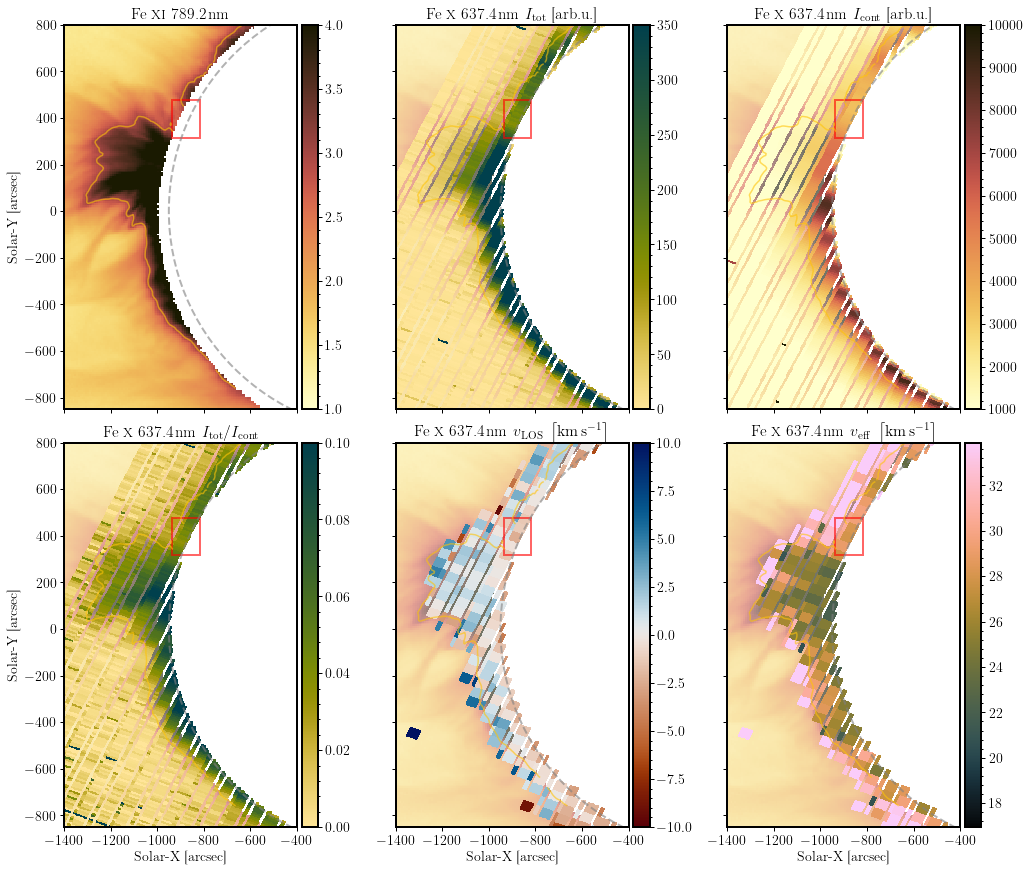

In [23]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

colorbar_width = "7%"

slit_xshift_red = sun_x_fitpoly(62) - slit_pos

slit_center_x_red =  - slit_xshift_red/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_red =  slit_xshift_red/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(14,12),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                    cmap=cmcm.lajolla,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

red_where_disk_ext = np.where((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)**2 < 940**2)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                        cmap=cmcm.lajolla,shading="auto",rasterized=True,alpha=0.6)

red_line_int_masked = np.copy(red_fit_matrix_ext[1,:,:])
red_line_int_masked[red_where_disk_ext] = np.nan

im2 = ax2.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_int_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=350)


plot_colorbar(im2, ax2,width=colorbar_width)

red_cont_masked = np.copy(red_fit_matrix_ext[3,:,:])
red_cont_masked[red_where_disk_ext] = np.nan
im3 = ax3.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)


red_line_cont_ratio_masked = red_fit_matrix_ext[1,:,:]/red_fit_matrix_ext[3,:,:]
red_line_cont_ratio_masked[red_where_disk_ext] = np.nan
im4 = ax4.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=0.1)

plot_colorbar(im4, ax4,width=colorbar_width)

red_where_disk_bin_ext = np.where((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2 < 940**2)

red_vlos_masked = -(np.copy(red_fit_matrix_bin_ext[0,:,:]) - 637.451)/637.451*const.c.cgs.value*1e-5
red_vlos_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked[red_where_disk_bin_ext] = np.nan
red_vlos_masked = red_vlos_masked - np.nanmedian(red_vlos_masked)
im5 = ax5.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

fwhm_masked = np.copy(red_fit_matrix_bin_ext[2,:,:])
fwhm_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
fwhm_masked[red_where_disk_bin_ext] = np.nan
im6 = ax6.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                np.sqrt(fwhm_masked**2 - inst_width_nm_red**2)/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,cmap=cmcm.batlowK,rasterized=True,vmin=0.06/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)),
                vmax=0.12/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xi} 789.2\,nm",fontsize=16)
ax2.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16)
ax3.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16)
ax4.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16)
ax5.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)
ax6.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)

xlim_zoomin = [-1400,-400]
ylim_zoomin = [-850,800]

for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,levels=[3],alpha=0.6,
            colors=['#FFC408'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)

In [24]:
def calc_distance(x,y,angle):
    k = np.tan(np.deg2rad(angle))
    return np.abs(k*x - y)/np.sqrt(k**2 + 1)

In [25]:
red_select_pos_1 = []
red_select_pos_1_angle = -10
for ii in range(56):
    index = np.argmin(calc_distance((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[:,ii],
                                    (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[:,ii],
                                    red_select_pos_1_angle))
    red_select_pos_1.append(index)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in sqrt


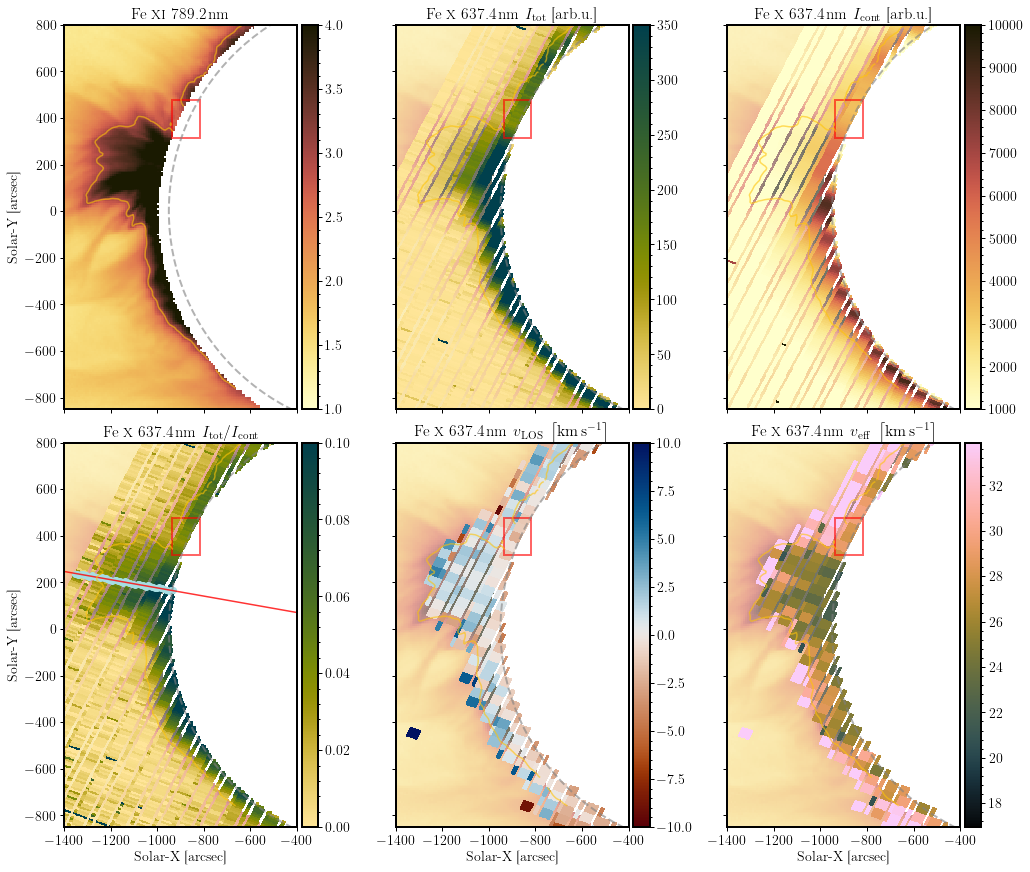

In [26]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(14,12),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                    cmap=cmcm.lajolla,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

red_where_disk_ext = np.where((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)**2 < 940**2)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                        cmap=cmcm.lajolla,shading="auto",rasterized=True,alpha=0.6)

red_line_int_masked = np.copy(red_fit_matrix_ext[1,:,:])
red_line_int_masked[red_where_disk_ext] = np.nan

im2 = ax2.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_int_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=350)


plot_colorbar(im2, ax2,width=colorbar_width)

red_cont_masked = np.copy(red_fit_matrix_ext[3,:,:])
red_cont_masked[red_where_disk_ext] = np.nan
im3 = ax3.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)


red_line_cont_ratio_masked = red_fit_matrix_ext[1,:,:]/red_fit_matrix_ext[3,:,:]
red_line_cont_ratio_masked[red_where_disk_ext] = np.nan
im4 = ax4.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=0.1)
ax4.axline((0,0),slope=np.tan(np.deg2rad(red_select_pos_1_angle)),color="red",alpha=0.8)

for ii, index_ in enumerate(red_select_pos_1):
    ax4.scatter((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii], 
                (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii],
                color="#A5DEE4")
plot_colorbar(im4, ax4,width=colorbar_width)

red_where_disk_bin_ext = np.where((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2 < 940**2)

red_vlos_masked = -(np.copy(red_fit_matrix_bin_ext[0,:,:]) - 637.451)/637.451*const.c.cgs.value*1e-5
red_vlos_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked[red_where_disk_bin_ext] = np.nan
red_vlos_masked = red_vlos_masked - np.nanmedian(red_vlos_masked)
im5 = ax5.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

fwhm_masked = np.copy(red_fit_matrix_bin_ext[2,:,:])
fwhm_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
fwhm_masked[red_where_disk_bin_ext] = np.nan
im6 = ax6.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                np.sqrt(fwhm_masked**2 - inst_width_nm_red**2)/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,cmap=cmcm.batlowK,rasterized=True,vmin=0.06/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)),
                vmax=0.12/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xi} 789.2\,nm",fontsize=16)
ax2.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16)
ax3.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16)
ax4.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16)
ax5.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)
ax6.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)

xlim_zoomin = [-1400,-400]
ylim_zoomin = [-850,800]

for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,levels=[3],alpha=0.6,
            colors=['#FFC408'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)

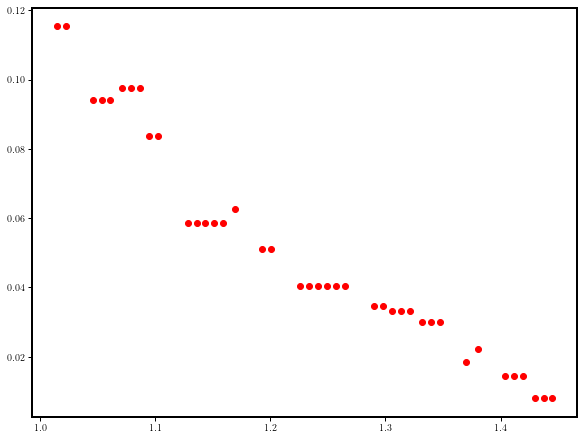

In [27]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
for ii, index_ in enumerate(red_select_pos_1):
    ax.scatter(np.sqrt(((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii])**2+ 
                ((y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii])**2)/950,
    red_line_cont_ratio_masked[index_,ii],color="red")

In [28]:
red_select_pos_2 = []
red_select_pos_2_angle = 20
for ii in range(93):
    index = np.argmin(calc_distance((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[:,ii],
                                    (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[:,ii],
                                    red_select_pos_2_angle))
    red_select_pos_2.append(index)

In [29]:
red_select_pos_3 = []
red_select_pos_3_angle = 100
for ii in range(102):
    index = np.argmin(calc_distance((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[:,ii],
                                    (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[:,ii],
                                    red_select_pos_3_angle))
    red_select_pos_3.append(index)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in sqrt


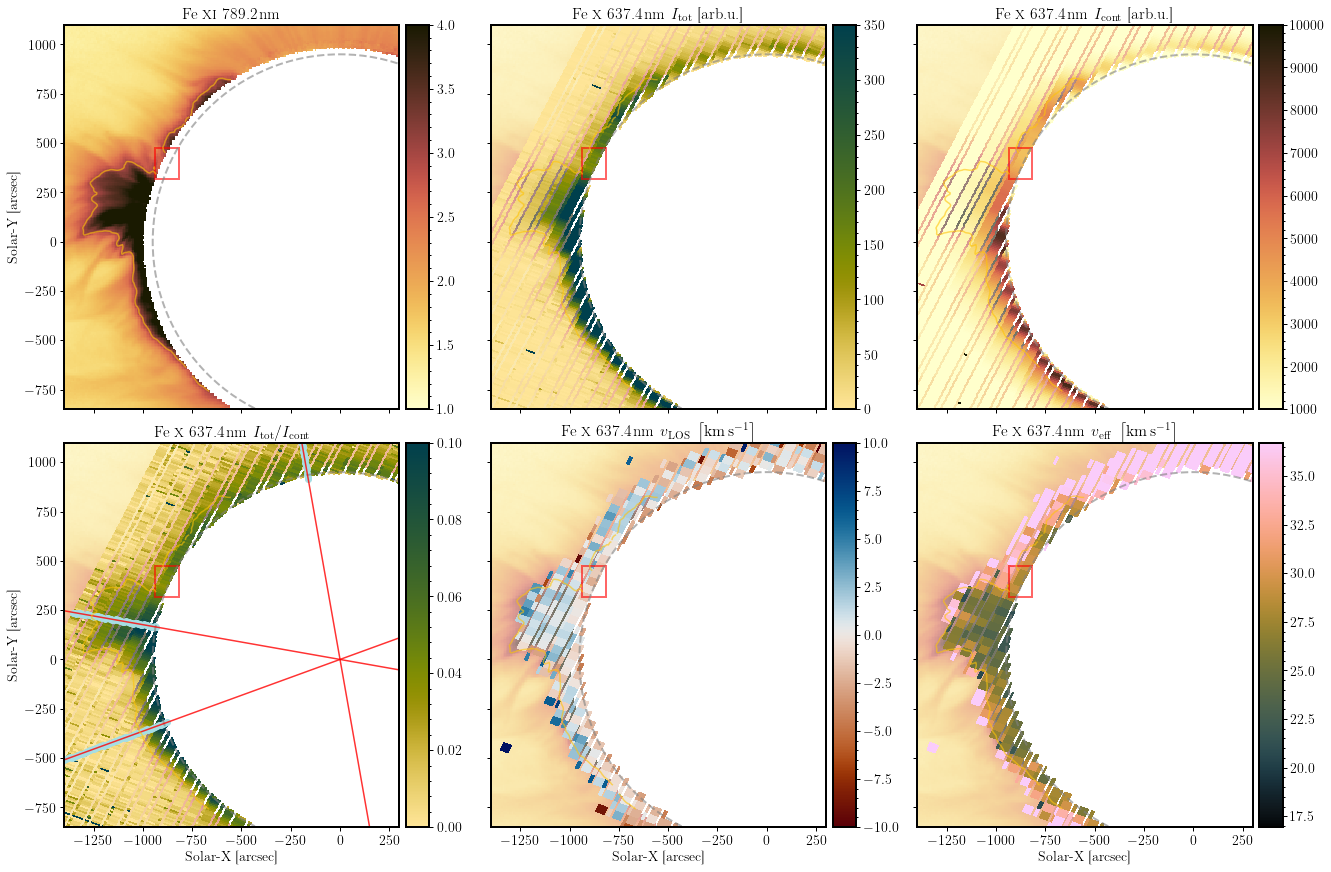

In [30]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(18,12),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                    cmap=cmcm.lajolla,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

red_where_disk_ext = np.where((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)**2 < 940**2)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                        cmap=cmcm.lajolla,shading="auto",rasterized=True,alpha=0.6)

red_line_int_masked = np.copy(red_fit_matrix_ext[1,:,:])
red_line_int_masked[red_where_disk_ext] = np.nan

im2 = ax2.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_int_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=350)


plot_colorbar(im2, ax2,width=colorbar_width)

red_cont_masked = np.copy(red_fit_matrix_ext[3,:,:])
red_cont_masked[red_where_disk_ext] = np.nan
im3 = ax3.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)


red_line_cont_ratio_masked = red_fit_matrix_ext[1,:,:]/red_fit_matrix_ext[3,:,:]
red_line_cont_ratio_masked[red_where_disk_ext] = np.nan
im4 = ax4.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=0.1)



ax4.axline((0,0),slope=np.tan(np.deg2rad(red_select_pos_1_angle)),color="red",alpha=0.8)
ax4.axline((0,0),slope=np.tan(np.deg2rad(red_select_pos_2_angle)),color="red",alpha=0.8)
ax4.axline((0,0),slope=np.tan(np.deg2rad(red_select_pos_3_angle)),color="red",alpha=0.8)

for ii, index_ in enumerate(red_select_pos_1):
    ax4.scatter((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii], 
                (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii],
                color="#A5DEE4")

for ii, index_ in enumerate(red_select_pos_2):
    ax4.scatter((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii], 
                (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii],
                color="#A5DEE4")

for ii, index_ in enumerate(red_select_pos_3):
    ax4.scatter((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii], 
                (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii],
                color="#A5DEE4")
plot_colorbar(im4, ax4,width=colorbar_width)

red_where_disk_bin_ext = np.where((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2 < 940**2)

red_vlos_masked = -(np.copy(red_fit_matrix_bin_ext[0,:,:]) - 637.451)/637.451*const.c.cgs.value*1e-5
red_vlos_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked[red_where_disk_bin_ext] = np.nan
red_vlos_masked = red_vlos_masked - np.nanmedian(red_vlos_masked)
im5 = ax5.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

fwhm_masked = np.copy(red_fit_matrix_bin_ext[2,:,:])
fwhm_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
fwhm_masked[red_where_disk_bin_ext] = np.nan
im6 = ax6.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                np.sqrt(fwhm_masked**2 - inst_width_nm_red**2)/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,cmap=cmcm.batlowK,rasterized=True,vmin=0.06/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)),
                vmax=0.13/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xi} 789.2\,nm",fontsize=16)
ax2.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16)
ax3.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16)
ax4.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16)
ax5.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)
ax6.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)

xlim_zoomin = [-1400,300]
ylim_zoomin = [-850,1100]

for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,levels=[3],alpha=0.6,
            colors=['#FFC408'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)

In [31]:
green_select_pos_1 = []
green_select_pos_1_angle = -10
for ii in range(75):
    index = np.argmin(calc_distance((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)[:,ii],
                                    (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)[:,ii],
                                    green_select_pos_1_angle))
    green_select_pos_1.append(index)

green_select_pos_2 = []
green_select_pos_2_angle = 20
for ii in range(115):
    index = np.argmin(calc_distance((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)[:,ii],
                                    (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)[:,ii],
                                    green_select_pos_2_angle))
    green_select_pos_2.append(index)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in sqrt


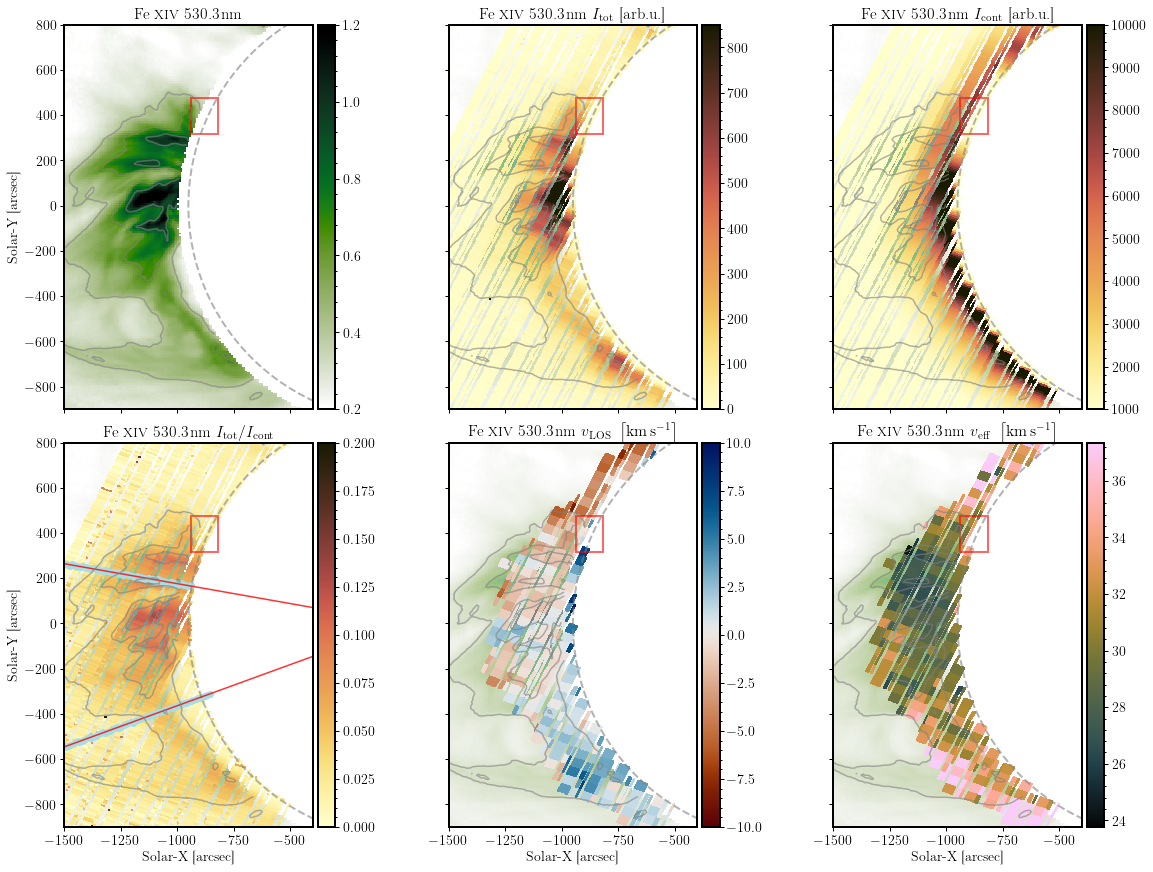

In [32]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)



colorbar_width = "7%"

def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,12),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True,alpha=0.5)

green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
green_line_int_masked[green_where_disk_ext] = np.nan

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=850)


plot_colorbar(im2, ax2,width=colorbar_width)

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:])
green_cont_masked[green_where_disk_ext] = np.nan
im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/green_fit_matrix_ext[3,:,:]
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan
im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.2)

ax4.axline((0,0),slope=np.tan(np.deg2rad(green_select_pos_1_angle)),color="red",alpha=0.8)
ax4.axline((0,0),slope=np.tan(np.deg2rad(green_select_pos_2_angle)),color="red",alpha=0.8)

for ii, index_ in enumerate(green_select_pos_1):
    ax4.scatter((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)[index_,ii], 
                (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)[index_,ii],
                color="#A5DEE4")

for ii, index_ in enumerate(green_select_pos_2):
    ax4.scatter((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)[index_,ii], 
                (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)[index_,ii],
                color="#A5DEE4")


plot_colorbar(im4, ax4,width=colorbar_width)

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 50)] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 50)] = np.nan
fwhm_masked[green_where_disk_bin_ext] = np.nan
im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                np.sqrt(fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,cmap=cmcm.batlowK,rasterized=True,vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.11/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3\,nm",fontsize=16)
ax2.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16)
ax3.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16)
ax4.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16)
ax5.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)
ax6.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)

xlim_zoomin = [-1500,-400]
ylim_zoomin = [-900,800]


for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)

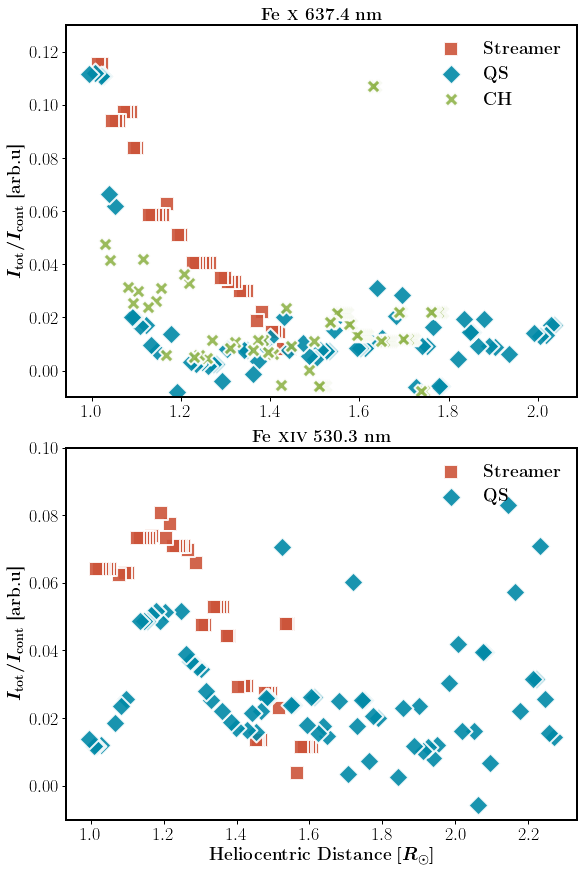

In [33]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,12),constrained_layout=True)

for ii, index_ in enumerate(red_select_pos_1):
    ln1 = ax1.scatter(np.sqrt(((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii])**2+ 
                ((y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii])**2)/950,
    red_line_cont_ratio_masked[index_,ii],marker= "s",s=200,facecolor="#CC543A",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{Streamer}")

for ii, index_ in enumerate(red_select_pos_2):
    ln2 = ax1.scatter(np.sqrt(((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii])**2+ 
                ((y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii])**2)/950,
    red_line_cont_ratio_masked[index_,ii],marker= "D",s=200,facecolor="#0089A7",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{QS}")

for ii, index_ in enumerate(red_select_pos_3):
    ln3 = ax1.scatter(np.sqrt(((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii])**2+ 
                ((y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii])**2)/950,
    red_line_cont_ratio_masked[index_,ii],marker= "X",s=200,facecolor="#90B44B",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{CH}")
leg_ax1 = [ln1,ln2,ln3]
ax1.legend(leg_ax1,[leg_.get_label() for leg_ in leg_ax1],fontsize=18,loc="upper right",frameon=False)
ax1.set_ylim(bottom=-0.01,top=0.13)
ax1.set_title(r"\textbf{Fe \textsc{x} 637.4 nm}",fontsize=18)
ax1.set_ylabel(r"$\boldsymbol{I_{\rm tot}/I_{\rm cont}}$ \textbf{[arb.u]}",fontsize=18)

for ii, index_ in enumerate(green_select_pos_1):
    ln1 = ax2.scatter(np.sqrt(((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)[index_,ii])**2+ 
                ((y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)[index_,ii])**2)/950,
    green_line_cont_ratio_masked[index_,ii],marker= "s",s=200,facecolor="#CC543A",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{Streamer}")

for ii, index_ in enumerate(green_select_pos_2):
    ln2 = ax2.scatter(np.sqrt(((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)[index_,ii])**2+ 
                ((y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)[index_,ii])**2)/950,
    green_line_cont_ratio_masked[index_,ii],marker= "D",s=200,facecolor="#0089A7",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{QS}")
leg_ax2 = [ln1,ln2]
ax2.legend(leg_ax2,[leg_.get_label() for leg_ in leg_ax2],fontsize=18,loc="upper right",frameon=False)
ax2.set_ylim(bottom=-0.01,top=0.1)
ax2.set_title(r"\textbf{Fe \textsc{xiv} 530.3 nm}",fontsize=18)
ax2.set_ylabel(r"$\boldsymbol{I_{\rm tot}/I_{\rm cont}}$ \textbf{[arb.u]}",fontsize=18)
ax2.set_xlabel(r"\textbf{Heliocentric Distance} $\boldsymbol{[R_\odot]}$",fontsize=18)

for ax_ in (ax1,ax2):
    ax_.tick_params(labelsize=18)




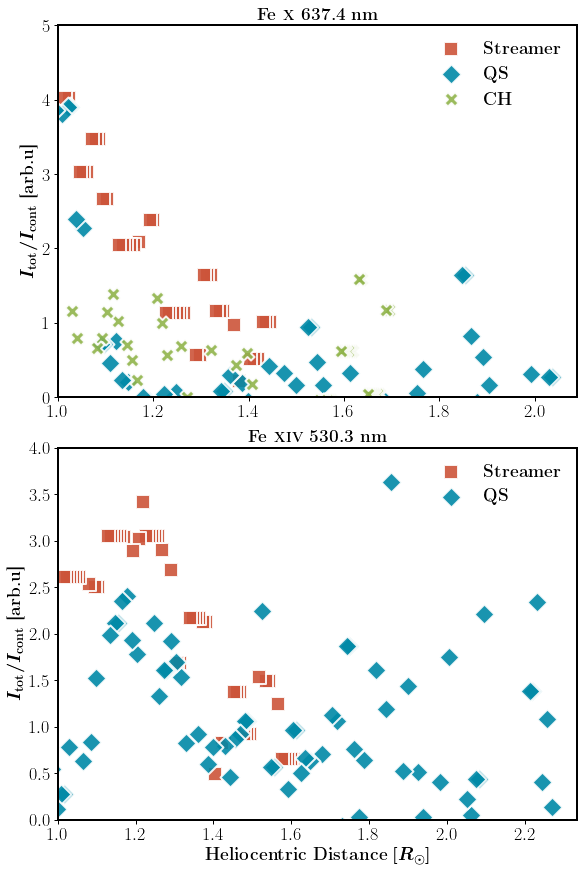

In [34]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,12),constrained_layout=True)

for ii, index_ in enumerate(red_select_pos_1):
    ln1 = ax1.scatter(np.sqrt(((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii])**2+ 
                ((y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii])**2)/950,
    (red_intensity_matrix/red_cont_matrix)[index_,ii],marker= "s",s=200,facecolor="#CC543A",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{Streamer}")

for ii, index_ in enumerate(red_select_pos_2):
    ln2 = ax1.scatter(np.sqrt(((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii])**2+ 
                ((y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii])**2)/950,
    (red_intensity_matrix/red_cont_matrix)[index_,ii],marker= "D",s=200,facecolor="#0089A7",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{QS}")

for ii, index_ in enumerate(red_select_pos_3):
    ln3 = ax1.scatter(np.sqrt(((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii])**2+ 
                ((y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii])**2)/950,
    (red_intensity_matrix/red_cont_matrix)[index_,ii],marker= "X",s=200,facecolor="#90B44B",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{CH}")
leg_ax1 = [ln1,ln2,ln3]
ax1.legend(leg_ax1,[leg_.get_label() for leg_ in leg_ax1],fontsize=18,loc="upper right",frameon=False)
ax1.set_title(r"\textbf{Fe \textsc{x} 637.4 nm}",fontsize=18)
ax1.set_ylabel(r"$\boldsymbol{I_{\rm tot}/I_{\rm cont}}$ \textbf{[arb.u]}",fontsize=18)

for ii, index_ in enumerate(green_select_pos_1):
    ln1 = ax2.scatter(np.sqrt(((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)[index_,ii])**2+ 
                ((y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)[index_,ii])**2)/950,
    (green_intensity_matrix/green_cont_matrix)[index_,ii],marker= "s",s=200,facecolor="#CC543A",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{Streamer}")

for ii, index_ in enumerate(green_select_pos_2):
    ln2 = ax2.scatter(np.sqrt(((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)[index_,ii])**2+ 
                ((y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)[index_,ii])**2)/950,
    (green_intensity_matrix/green_cont_matrix)[index_,ii],marker= "D",s=200,facecolor="#0089A7",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{QS}")
leg_ax2 = [ln1,ln2]
ax2.legend(leg_ax2,[leg_.get_label() for leg_ in leg_ax2],fontsize=18,loc="upper right",frameon=False)
ax2.set_title(r"\textbf{Fe \textsc{xiv} 530.3 nm}",fontsize=18)
ax2.set_ylabel(r"$\boldsymbol{I_{\rm tot}/I_{\rm cont}}$ \textbf{[arb.u]}",fontsize=18)
ax2.set_xlabel(r"\textbf{Heliocentric Distance} $\boldsymbol{[R_\odot]}$",fontsize=18)
ax1.set_ylim(0,5)
ax2.set_ylim(0,4)
for ax_ in (ax1,ax2):
    ax_.tick_params(labelsize=18)
    ax_.set_xlim(left=1.0)




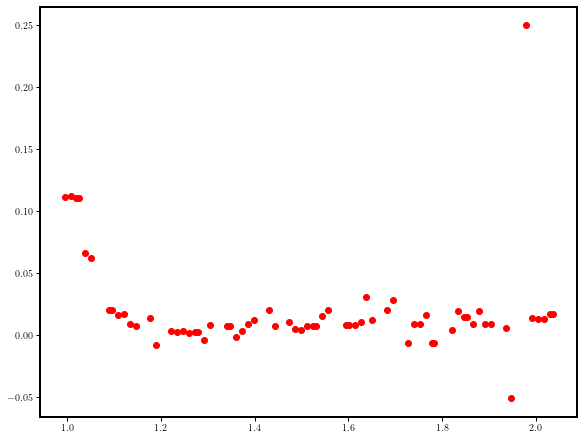

In [35]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
for ii, index_ in enumerate(red_select_pos_2):
    ax.scatter(np.sqrt(((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)[index_,ii])**2+ 
                ((y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)[index_,ii])**2)/950,
    red_line_cont_ratio_masked[index_,ii],color="red")

In [39]:
def check_fit_profile(xgrid,ygrid,fit_matrix,title=None):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot([1,2,3],[2,3,4])
    cid = fig.canvas.mpl_connect('button_press_event',mouse_event)
    plt.show()



def mouse_event(event):
    print("x:{} y:{}".format(event.xdata,event.ydata))

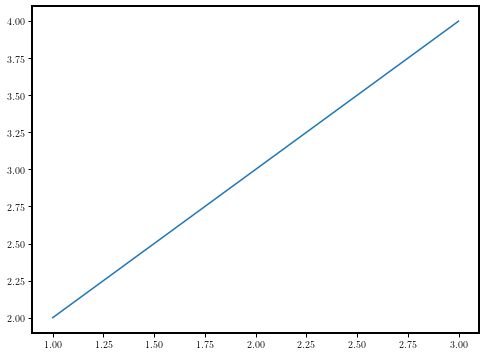

In [40]:
check_fit_profile(0,0,0)